This notebook will experiment on quick draw dataset which you download on Kaggel.

### Model Parameters

In [1]:
batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50
LEARNING_RATE = 0.0005  # 0.0001   0.0005   0.001   0.005, select one of the lr to train

In [68]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()
def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
base_dir = os.path.join('.', 'input')
test_path = os.path.join(base_dir, 'test_simplified.csv')

In [69]:
from keras.engine import Layer, InputSpec
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [70]:
from ast import literal_eval
ALL_TRAIN_PATHS = glob(os.path.join(base_dir, 'train_simplified', '*.csv'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    """preprocess the string and make 
    a standard Nx3 stroke vector"""
    stroke_vec = literal_eval(raw_strokes) # string->list
    # unwrap the list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    # replace stroke id with 1 for continue, 2 for new
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1 # since 0 is no stroke
    # pad the strokes with zeros
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)
def read_batch(samples=5, 
               start_row=0,
               max_rows = 1000):
    """
    load and process the csv files
    this function is horribly inefficient but simple
    """
    out_df_list = []
    for c_path in ALL_TRAIN_PATHS:
        c_df = pd.read_csv(c_path, nrows=max_rows, skiprows=start_row)
        c_df.columns=COL_NAMES
        out_df_list += [c_df.sample(samples)[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

# Reading and Parsing
Since it is too much data (23GB) to read in at once, we just take a portion of it for training, validation and hold-out testing. This should give us an idea about how well the model works, but leaves lots of room for improvement later

In [71]:
train_args = dict(samples=TRAIN_SAMPLES, 
                  start_row=0, 
                  max_rows=int(TRAIN_SAMPLES*1.5))
valid_args = dict(samples=VALID_SAMPLES, 
                  start_row=train_args['max_rows']+1, 
                  max_rows=VALID_SAMPLES+25)
test_args = dict(samples=TEST_SAMPLES, 
                 start_row=valid_args['max_rows']+train_args['max_rows']+1, 
                 max_rows=TEST_SAMPLES+25)
train_df = read_batch(**train_args)
valid_df = read_batch(**valid_args)
test_df = read_batch(**test_args)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])

words 340 => The Eiffel Tower, The Great Wall of China, The Mona Lisa, airplane, alarm clock, ambulance, angel, animal migration, ant, anvil, apple, arm, asparagus, axe, backpack, banana, bandage, barn, baseball, baseball bat, basket, basketball, bat, bathtub, beach, bear, beard, bed, bee, belt, bench, bicycle, binoculars, bird, birthday cake, blackberry, blueberry, book, boomerang, bottlecap, bowtie, bracelet, brain, bread, bridge, broccoli, broom, bucket, bulldozer, bus, bush, butterfly, cactus, cake, calculator, calendar, camel, camera, camouflage, campfire, candle, cannon, canoe, car, carrot, castle, cat, ceiling fan, cell phone, cello, chair, chandelier, church, circle, clarinet, clock, cloud, coffee cup, compass, computer, cookie, cooler, couch, cow, crab, crayon, crocodile, crown, cruise ship, cup, diamond, dishwasher, diving board, dog, dolphin, donut, door, dragon, dresser, drill, drums, duck, dumbbell, ear, elbow, elephant, envelope, eraser, eye, eyeglasses, face, fan, feathe

# Stroke-based Classification
Here we use the stroke information to train a model and see if the strokes give us a better idea of what the shape could be. 

In [72]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)

(10200, 196, 3)


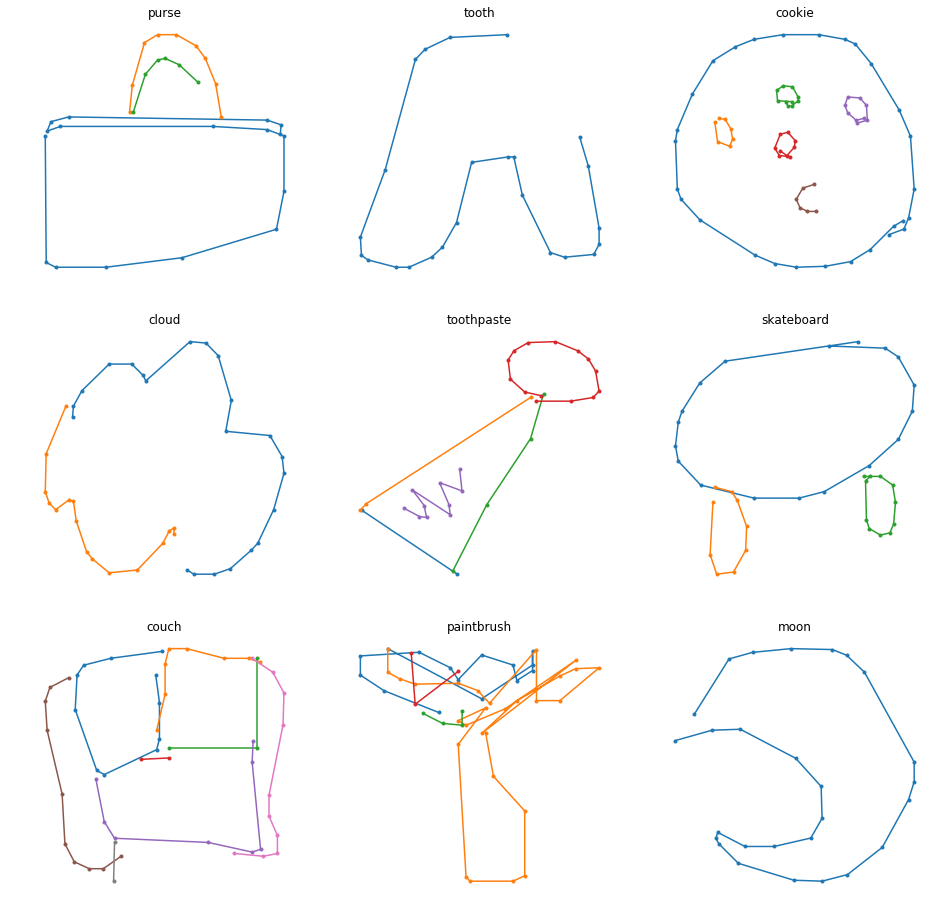

In [73]:
fig, m_axs = plt.subplots(3,3, figsize = (16, 16))
rand_idxs = np.random.choice(range(train_X.shape[0]), size = 9)
for c_id, c_ax in zip(rand_idxs, m_axs.flatten()):
    test_arr = train_X[c_id]
    test_arr = test_arr[test_arr[:,2]>0, :] # only keep valid points
    lab_idx = np.cumsum(test_arr[:,2]-1)
    for i in np.unique(lab_idx):
        c_ax.plot(test_arr[lab_idx==i,0], 
                np.max(test_arr[:,1])-test_arr[lab_idx==i,1], '.-')
    c_ax.axis('off')
    c_ax.set_title(word_encoder.classes_[np.argmax(train_y[c_id])])

In [74]:
import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
from keras import optimizers
if len(get_available_gpus())>0:
    # https://twitter.com/fchollet/status/918170264608817152?lang=en
    from keras.layers import CuDNNLSTM as LSTM # this one is about 3x faster on GPU instances
    
sgd = optimizers.SGD(lr=LEARNING_RATE, decay=0, momentum=0.9, nesterov=True)

# Group Norm

In [75]:
stroke_read_model_gn = Sequential()
stroke_read_model_gn.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model_gn.add(Conv1D(48, (5,)))
stroke_read_model_gn.add(GroupNormalization(groups=4, axis=-1, epsilon=1e-5))
stroke_read_model_gn.add(Dropout(0.3))
stroke_read_model_gn.add(Conv1D(64, (5,)))
stroke_read_model_gn.add(GroupNormalization(groups=4, axis=-1, epsilon=1e-5))
stroke_read_model_gn.add(Dropout(0.3))
stroke_read_model_gn.add(Conv1D(96, (3,)))
stroke_read_model_gn.add(GroupNormalization(groups=4, axis=-1, epsilon=1e-5))
stroke_read_model_gn.add(Dropout(0.3))
stroke_read_model_gn.add(LSTM(128, return_sequences = True))
stroke_read_model_gn.add(Dropout(0.3))
stroke_read_model_gn.add(LSTM(128, return_sequences = False))
stroke_read_model_gn.add(Dropout(0.3))
stroke_read_model_gn.add(Dense(512))
stroke_read_model_gn.add(Dropout(0.3))
stroke_read_model_gn.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model_gn.compile(optimizer = sgd, 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model_gn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, None, 3)           12        
_________________________________________________________________
conv1d_41 (Conv1D)           (None, None, 48)          768       
_________________________________________________________________
group_normalization_22 (Grou (None, None, 48)          96        
_________________________________________________________________
dropout_79 (Dropout)         (None, None, 48)          0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, None, 64)          15424     
_________________________________________________________________
group_normalization_23 (Grou (None, None, 64)          128       
_________________________________________________________________
dropout_80 (Dropout)         (None, None, 64)          0         
__________

# Batch Norm

In [76]:
stroke_read_model_bn = Sequential()
stroke_read_model_bn.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model_bn.add(Conv1D(48, (5,)))
stroke_read_model_bn.add(BatchNormalization())
stroke_read_model_bn.add(Dropout(0.3))
stroke_read_model_bn.add(Conv1D(64, (5,)))
stroke_read_model_bn.add(BatchNormalization())
stroke_read_model_bn.add(Dropout(0.3))
stroke_read_model_bn.add(Conv1D(96, (3,)))
stroke_read_model_bn.add(BatchNormalization())
stroke_read_model_bn.add(Dropout(0.3))
stroke_read_model_bn.add(LSTM(128, return_sequences = True))
stroke_read_model_bn.add(Dropout(0.3))
stroke_read_model_bn.add(LSTM(128, return_sequences = False))
stroke_read_model_bn.add(Dropout(0.3))
stroke_read_model_bn.add(Dense(512))
stroke_read_model_bn.add(Dropout(0.3))
stroke_read_model_bn.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model_bn.compile(optimizer = sgd, 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_26 (Batc (None, None, 3)           12        
_________________________________________________________________
conv1d_44 (Conv1D)           (None, None, 48)          768       
_________________________________________________________________
batch_normalization_27 (Batc (None, None, 48)          192       
_________________________________________________________________
dropout_85 (Dropout)         (None, None, 48)          0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, None, 64)          15424     
_________________________________________________________________
batch_normalization_28 (Batc (None, None, 64)          256       
_________________________________________________________________
dropout_86 (Dropout)         (None, None, 64)          0         
__________

# No Norm

In [77]:
stroke_read_model_std = Sequential()
stroke_read_model_std.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
stroke_read_model_std.add(Conv1D(48, (5,)))
stroke_read_model_std.add(Dropout(0.3))
stroke_read_model_std.add(Conv1D(64, (5,)))
stroke_read_model_std.add(Dropout(0.3))
stroke_read_model_std.add(Conv1D(96, (3,)))
stroke_read_model_std.add(Dropout(0.3))
stroke_read_model_std.add(LSTM(128, return_sequences = True))
stroke_read_model_std.add(Dropout(0.3))
stroke_read_model_std.add(LSTM(128, return_sequences = False))
stroke_read_model_std.add(Dropout(0.3))
stroke_read_model_std.add(Dense(512))
stroke_read_model_std.add(Dropout(0.3))
stroke_read_model_std.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model_std.compile(optimizer = sgd, 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model_std.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_30 (Batc (None, None, 3)           12        
_________________________________________________________________
conv1d_47 (Conv1D)           (None, None, 48)          768       
_________________________________________________________________
dropout_91 (Dropout)         (None, None, 48)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, None, 64)          15424     
_________________________________________________________________
dropout_92 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, None, 96)          18528     
_________________________________________________________________
dropout_93 (Dropout)         (None, None, 96)          0         
__________

## keras Callbacks

In [78]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

# reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
#                                    verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=5) # probably needs to be more patient, but kaggle time is limited

In [79]:
history_gn = LossHistory()
history_bn = LossHistory()
history_std = LossHistory()
weight_path_gn = "{}_weights.best.hdf5".format('stroke_lstm_model_gn')
weight_path_bn = "{}_weights.best.hdf5".format('stroke_lstm_model_bn')
weight_path_std = "{}_weights.best.hdf5".format('stroke_lstm_model_std')
callbacks_list_gn = [checkpoint, history_gn]
callbacks_list_bn = [checkpoint, history_bn]
callbacks_list_std = [checkpoint, history_std]

## Fit Group Norm

In [80]:
stroke_read_model_gn.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list_gn)

Train on 10200 samples, validate on 3400 samples
Epoch 1/50
10200/10200 [==============================] - 26s 3ms/step - loss: 5.8495 - categorical_accuracy: 0.0028 - top_3_accuracy: 0.0080 - val_loss: 5.8307 - val_categorical_accuracy: 0.0026 - val_top_3_accuracy: 0.0088

Epoch 00001: val_loss improved from inf to 5.83075, saving model to stroke_lstm_model_weights.best.hdf5
Epoch 2/50
10200/10200 [==============================] - 20s 2ms/step - loss: 5.8325 - categorical_accuracy: 0.0024 - top_3_accuracy: 0.0075 - val_loss: 5.8248 - val_categorical_accuracy: 0.0038 - val_top_3_accuracy: 0.0106

Epoch 00002: val_loss improved from 5.83075 to 5.82480, saving model to stroke_lstm_model_weights.best.hdf5
Epoch 3/50
10200/10200 [==============================] - 20s 2ms/step - loss: 5.8276 - categorical_accuracy: 0.0023 - top_3_accuracy: 0.0073 - val_loss: 5.8265 - val_categorical_accuracy: 0.0038 - val_top_3_accuracy: 0.0100

Epoch 00003: val_loss did not improve from 5.82480
Epoch 4/50

KeyboardInterrupt: 

## Fit Batch Norm

In [ ]:
stroke_read_model_bn.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list_bn)

## Fit No Norm

In [ ]:
stroke_read_model_std.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 50,
                      callbacks = callbacks_list_std)

## Save losses

In [ ]:
import pickle 

with open('gn_'+LEARNING_RATE+'.pickle', 'wb') as f:
    pickle.dump(history_gn.losses, f, pickle.HIGHEST_PROTOCOL)
    
with open('bn_'+LEARNING_RATE+'.pickle', 'wb') as f:
    pickle.dump(history_bn.losses, f, pickle.HIGHEST_PROTOCOL)
    
with open('std_'+LEARNING_RATE+'.pickle', 'wb') as f:
    pickle.dump(history_std.losses, f, pickle.HIGHEST_PROTOCOL)

## Plot loss of over batches

In [ ]:
plt.plot(history_gn.losses)
plt.plot(history_bn.losses)
plt.plot(history_std.losses)
plt.title('Losses over batches')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(['Standard + GroupNorm', 'Standard + BatchNorm', 'Standard'], loc='upper right')
# plt.show()
plt.savefig('4_444.png', dpi=400)

## Test Group Norm

In [1]:
stroke_read_model_gn.load_weights(weight_path_gn)
lstm_results_gn = stroke_read_model_gn.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results_gn[1], 100*lstm_results_gn[2]))

NameError: name 'stroke_read_model' is not defined

## Test Batch Norm

In [1]:
stroke_read_model_bn.load_weights(weight_path_bn)
lstm_results_bn = stroke_read_model_bn.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results_bn[1], 100*lstm_results_bn[2]))

NameError: name 'stroke_read_model' is not defined

## Test No Norm

In [1]:
stroke_read_model_std.load_weights(weight_path_std)
lstm_results_std = stroke_read_model_std.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results_std[1], 100*lstm_results_std[2]))

NameError: name 'stroke_read_model' is not defined

# End